# Loading the data

Load the training and test data, both of the dataset is balanced. 'Class Index' column represents the classes

* 1 represents "world news"
* 2 represents "sports news"
* 3 represents "business news"
* 4 represents "science technology news"



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import html
from bs4 import BeautifulSoup

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
train_data = pd.read_csv('/content/train_subset_400.csv')
test_data = pd.read_csv('/content/test.csv')

In [3]:
def clean_text(text):

    # Step 1) 
    # Remove all <a> tags and their content (links)
    soup = BeautifulSoup(text, "html.parser")
    for a_tag in soup.find_all('a'):
        a_tag.decompose()  # Removes the <a> tag completely

    # Extract the cleaned text
    cleaned_text = soup.get_text()

    # Step 2) 
    # Remove extra spaces and unwanted characters
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()

    # Step 3) 
    # Remove backslashes
    cleaned_text = re.sub(r'\\', ' ', cleaned_text)

    # Step 4) 
    # Explicitly replace #39; with an apostrophe and remove space before 's
    cleaned_text = re.sub(r'#39;', "'", cleaned_text)
    cleaned_text = re.sub(r"\s+'s", "'s", cleaned_text)

    # Replace #36; with $ sign
    cleaned_text = re.sub(r'#36;', '$', cleaned_text)

    return cleaned_text

In [4]:
train_data['raw_text'] = train_data['Title'] + '. ' + train_data['Description']
train_data['labels'] = train_data['Class Index'] - 1 # did this for the distBERT model
train_data['text'] = train_data['raw_text'].apply(clean_text)
train_data.drop(['Title', 'Description', 'raw_text', 'Class Index'], inplace=True, axis=1)
train_data.head()

<ipython-input-3-a8185251c626>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


,labels,text
0,0,"Explosion Rocks Baghdad Neighborhood. BAGHDAD,..."
1,0,BBC reporters' log. BBC correspondents record ...
2,0,Israel welcomes Rice nomination; Palestinians ...
3,0,Medical Journal Calls for a New Drug Watchdog....
4,0,Militants Kidnap Relatives of Iraqi Minister-T...


In [5]:
# Note that test data is balanced as well, 1900 samples from each class
test_data['raw_text'] = test_data['Title'] + '. ' + test_data['Description']
test_data['labels'] = test_data['Class Index'] - 1
test_data['text'] = test_data['raw_text'].apply(clean_text)
test_data.drop(['Title', 'Description', 'raw_text', 'Class Index'], inplace=True, axis=1)
test_data.head()

<ipython-input-3-a8185251c626>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


,labels,text
0,2,Fears for T N pension after talks. Unions repr...
1,3,The Race is On: Second Private Team Sets Launc...
2,3,Ky. Company Wins Grant to Study Peptides (AP)....
3,3,Prediction Unit Helps Forecast Wildfires (AP)....
4,3,Calif. Aims to Limit Farm-Related Smog (AP). A...


# Traditional Baseline Models

In [6]:
x_train, y_train = train_data['text'], train_data['labels']
x_test, y_test = test_data['text'], test_data['labels']

## Naive Bayes Classifier

Accuracy (test data) = 0.7943
Classification report:
               precision    recall  f1-score   support

           0       0.81      0.83      0.82      1900
           1       0.86      0.89      0.87      1900
           2       0.74      0.75      0.74      1900
           3       0.77      0.72      0.74      1900

    accuracy                           0.79      7600
   macro avg       0.79      0.79      0.79      7600
weighted avg       0.79      0.79      0.79      7600



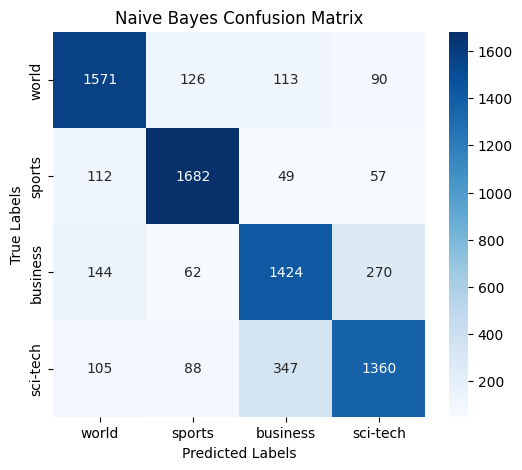

In [7]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

clf = make_pipeline(
    CountVectorizer(), # vectorize the speeches
    MultinomialNB() # fit Naive Bayes model
)

clf.fit(x_train, y_train)
y_pred_nb = clf.predict(x_test)
acc_nb= np.mean(y_test == y_pred_nb)
print(f"Accuracy (test data) = {acc_nb:.4f}")

print("Classification report:\n", classification_report(y_test, y_pred_nb))

cm_nb = confusion_matrix(y_test, y_pred_nb, labels=[0,1,2,3])
plt.figure(figsize=(6, 5))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', xticklabels=["world", "sports", "business", "sci-tech"], yticklabels=["world", "sports", "business", "sci-tech"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Naive Bayes Confusion Matrix')
plt.show()

## Logistic Regression Model

Accuracy (test data) = 0.7795
Classification report:
               precision    recall  f1-score   support

           0       0.78      0.81      0.79      1900
           1       0.82      0.90      0.86      1900
           2       0.75      0.71      0.73      1900
           3       0.76      0.71      0.73      1900

    accuracy                           0.78      7600
   macro avg       0.78      0.78      0.78      7600
weighted avg       0.78      0.78      0.78      7600



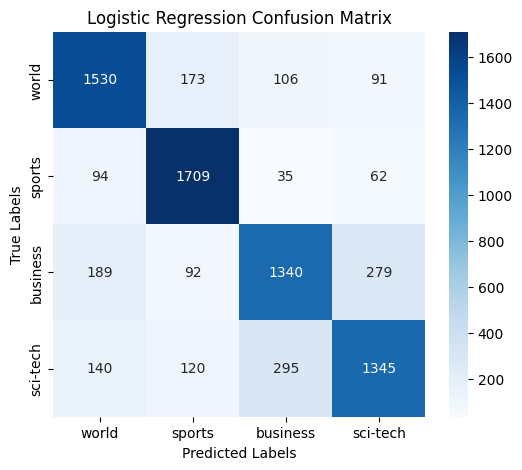

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

x_train, y_train = train_data['text'], train_data['labels']
x_test, y_test = test_data['text'], test_data['labels']

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

# Transform the text data
x_train_tfidf = vectorizer.fit_transform(x_train)
x_test_tfidf = vectorizer.transform(x_test)

model_logistic = LogisticRegression() 
model_logistic.fit(x_train_tfidf, y_train)

y_pred_log = model_logistic.predict(x_test_tfidf)

acc_logistic = np.mean(y_test == y_pred_log)
print(f"Accuracy (test data) = {acc_logistic:.4f}")

print("Classification report:\n", classification_report(y_test, y_pred_log))

cm_logistic = confusion_matrix(y_test, y_pred_log, labels=[0,1,2,3])
cm_logistic
plt.figure(figsize=(6, 5))
sns.heatmap(cm_logistic, annot=True, fmt='d', cmap='Blues', xticklabels=["world", "sports", "business", "sci-tech"], yticklabels=["world", "sports", "business", "sci-tech"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

# DistilBERT Model

In [9]:
# Importing stock ml libraries
import warnings
warnings.simplefilter('ignore')
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import DistilBertTokenizer, DistilBertModel
import logging
logging.basicConfig(level=logging.ERROR)

import torch.nn.functional as F  # For softmax

In [10]:
# # Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [11]:
# Adding tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', truncation=True, do_lower_case=True, padding = True)

max_token_length = train_data['text'].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=True))).max()
print("Maximum token length in the train data:", max_token_length)

Maximum token length in the train data: 195


In [12]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 256
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16

In [13]:
class MultiClassDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.targets = self.data.labels # They are integers which are 0,1,2,3
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]
        target = self.targets[index]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [14]:
# Dataloader for the neural network

print("TRAIN Dataset: {}".format(train_data.shape))
print("TEST Dataset: {}".format(test_data.shape))

training_set = MultiClassDataset(train_data, tokenizer, MAX_LEN)
testing_set = MultiClassDataset(test_data, tokenizer, MAX_LEN)

TRAIN Dataset: (400, 2)
TEST Dataset: (7600, 2)


In [15]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [16]:
# Necessary functions and DistilBERT class

class DistilBERTClass(torch.nn.Module):
    def __init__(self, hidden_size, dropout_rate):
        super(DistilBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, hidden_size) # This is about structure of the model
        self.dropout = torch.nn.Dropout(dropout_rate) # for regularization
        self.classifier = torch.nn.Linear(hidden_size, 4) # number of classes is 4

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

def train(model, epoch):
    model.train()
    for _,data in tqdm(enumerate(training_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        if _%5000==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')

        loss.backward()
        optimizer.step()

def validation(model, testing_loader):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)

            # Forward pass through the model and applying softmax
            outputs = model(ids, mask, token_type_ids)
            outputs_probs = F.softmax(outputs, dim=1)

            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(outputs_probs.cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Testing combination: Hidden Size=256, Dropout=0.2, Epoch=3


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Epoch: 0, Loss:  1.3999719619750977


25it [00:08,  2.83it/s]
1it [00:00,  2.61it/s]

Epoch: 1, Loss:  1.2915382385253906


25it [00:07,  3.17it/s]
1it [00:00,  2.51it/s]

Epoch: 2, Loss:  0.8705330491065979


25it [00:08,  3.10it/s]
475it [01:06,  7.11it/s]


Accuracy (test data) = 0.8567105263157895
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.86      0.87      1900
           1       0.94      0.99      0.96      1900
           2       0.74      0.88      0.80      1900
           3       0.89      0.70      0.78      1900

    accuracy                           0.86      7600
   macro avg       0.86      0.86      0.86      7600
weighted avg       0.86      0.86      0.86      7600



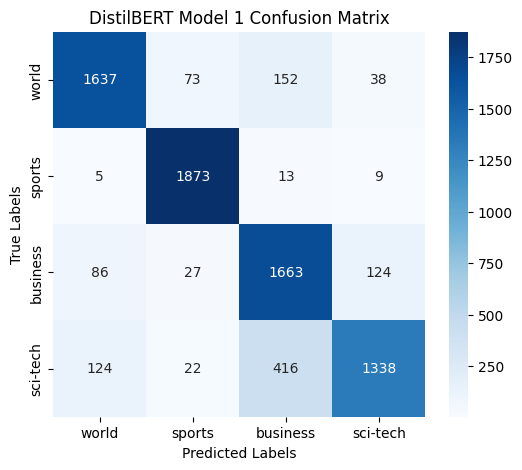

Model saved as /content/drive/MyDrive/DistilBERT_Models_400/model_1.pth
Best model updated!

Testing combination: Hidden Size=256, Dropout=0.2, Epoch=5


1it [00:00,  4.53it/s]

Epoch: 0, Loss:  1.49617338180542


25it [00:07,  3.23it/s]
1it [00:00,  2.61it/s]

Epoch: 1, Loss:  1.2694239616394043


25it [00:07,  3.17it/s]
1it [00:00,  2.54it/s]

Epoch: 2, Loss:  0.868768572807312


25it [00:07,  3.16it/s]
1it [00:00,  2.54it/s]

Epoch: 3, Loss:  0.4818801283836365


25it [00:07,  3.16it/s]
1it [00:00,  2.63it/s]

Epoch: 4, Loss:  0.40561699867248535


25it [00:07,  3.15it/s]
475it [00:57,  8.30it/s]


Accuracy (test data) = 0.8690789473684211
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.87      0.88      1900
           1       0.95      0.98      0.96      1900
           2       0.78      0.84      0.81      1900
           3       0.86      0.78      0.82      1900

    accuracy                           0.87      7600
   macro avg       0.87      0.87      0.87      7600
weighted avg       0.87      0.87      0.87      7600



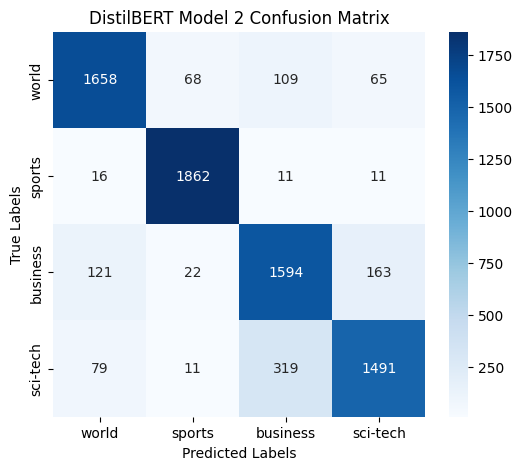

Model saved as /content/drive/MyDrive/DistilBERT_Models_400/model_2.pth
Best model updated!

Testing combination: Hidden Size=256, Dropout=0.5, Epoch=3


1it [00:00,  7.63it/s]

Epoch: 0, Loss:  1.417040228843689


25it [00:07,  3.29it/s]
1it [00:00,  2.56it/s]

Epoch: 1, Loss:  1.3307961225509644


25it [00:07,  3.18it/s]
1it [00:00,  2.46it/s]

Epoch: 2, Loss:  1.0992869138717651


25it [00:07,  3.17it/s]
475it [00:56,  8.39it/s]


Accuracy (test data) = 0.8642105263157894
Classification report:
               precision    recall  f1-score   support

           0       0.93      0.84      0.88      1900
           1       0.92      0.98      0.95      1900
           2       0.75      0.85      0.80      1900
           3       0.87      0.78      0.82      1900

    accuracy                           0.86      7600
   macro avg       0.87      0.86      0.86      7600
weighted avg       0.87      0.86      0.86      7600



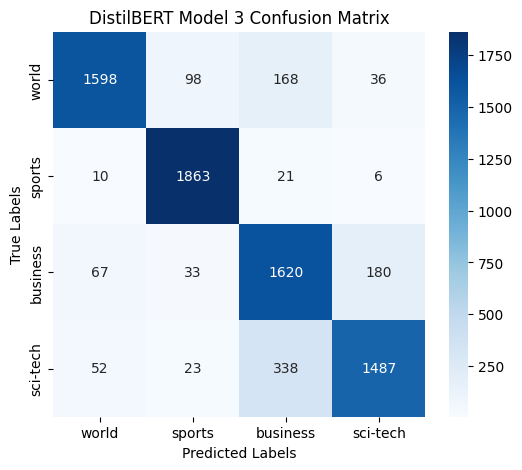

Model saved as /content/drive/MyDrive/DistilBERT_Models_400/model_3.pth

Testing combination: Hidden Size=256, Dropout=0.5, Epoch=5


1it [00:00,  8.00it/s]

Epoch: 0, Loss:  1.4487532377243042


25it [00:07,  3.30it/s]
1it [00:00,  2.54it/s]

Epoch: 1, Loss:  1.2507539987564087


25it [00:07,  3.17it/s]
1it [00:00,  2.55it/s]

Epoch: 2, Loss:  0.9303777813911438


25it [00:07,  3.18it/s]
1it [00:00,  2.57it/s]

Epoch: 3, Loss:  0.6290391087532043


25it [00:07,  3.18it/s]
1it [00:00,  2.54it/s]

Epoch: 4, Loss:  0.5093629956245422


25it [00:07,  3.18it/s]
475it [00:56,  8.44it/s]


Accuracy (test data) = 0.88
Classification report:
               precision    recall  f1-score   support

           0       0.92      0.85      0.88      1900
           1       0.95      0.97      0.96      1900
           2       0.81      0.83      0.82      1900
           3       0.84      0.87      0.86      1900

    accuracy                           0.88      7600
   macro avg       0.88      0.88      0.88      7600
weighted avg       0.88      0.88      0.88      7600



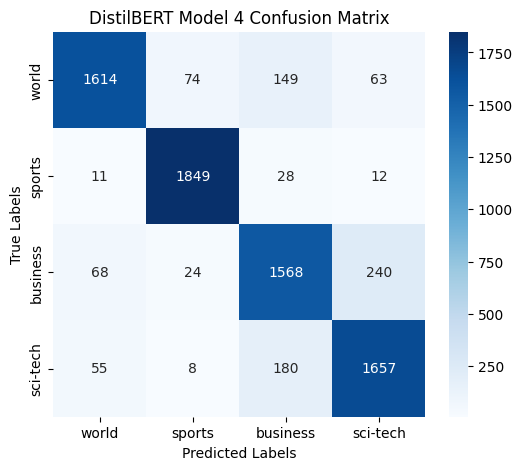

Model saved as /content/drive/MyDrive/DistilBERT_Models_400/model_4.pth
Best model updated!

Testing combination: Hidden Size=768, Dropout=0.2, Epoch=3


1it [00:00,  5.05it/s]

Epoch: 0, Loss:  1.380042314529419


25it [00:07,  3.27it/s]
1it [00:00,  2.53it/s]

Epoch: 1, Loss:  1.2818527221679688


25it [00:07,  3.16it/s]
1it [00:00,  2.53it/s]

Epoch: 2, Loss:  1.0359392166137695


25it [00:07,  3.17it/s]
475it [00:56,  8.39it/s]


Accuracy (test data) = 0.8692105263157894
Classification report:
               precision    recall  f1-score   support

           0       0.85      0.90      0.87      1900
           1       0.95      0.98      0.96      1900
           2       0.81      0.81      0.81      1900
           3       0.87      0.79      0.83      1900

    accuracy                           0.87      7600
   macro avg       0.87      0.87      0.87      7600
weighted avg       0.87      0.87      0.87      7600



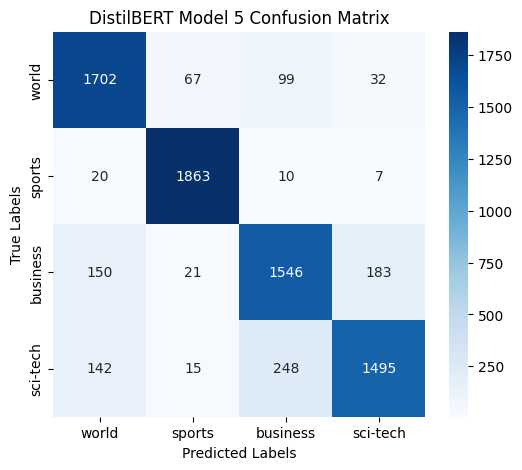

Model saved as /content/drive/MyDrive/DistilBERT_Models_400/model_5.pth

Testing combination: Hidden Size=768, Dropout=0.2, Epoch=5


1it [00:00,  5.05it/s]

Epoch: 0, Loss:  1.4157730340957642


25it [00:07,  3.26it/s]
1it [00:00,  2.54it/s]

Epoch: 1, Loss:  1.2369879484176636


25it [00:07,  3.17it/s]
1it [00:00,  2.53it/s]

Epoch: 2, Loss:  0.8350997567176819


25it [00:07,  3.17it/s]
1it [00:00,  2.53it/s]

Epoch: 3, Loss:  0.35289549827575684


25it [00:07,  3.17it/s]
1it [00:00,  2.58it/s]

Epoch: 4, Loss:  0.3661845326423645


25it [00:07,  3.18it/s]
475it [00:56,  8.35it/s]


Accuracy (test data) = 0.8832894736842105
Classification report:
               precision    recall  f1-score   support

           0       0.90      0.87      0.88      1900
           1       0.94      0.98      0.96      1900
           2       0.86      0.80      0.83      1900
           3       0.83      0.89      0.86      1900

    accuracy                           0.88      7600
   macro avg       0.88      0.88      0.88      7600
weighted avg       0.88      0.88      0.88      7600



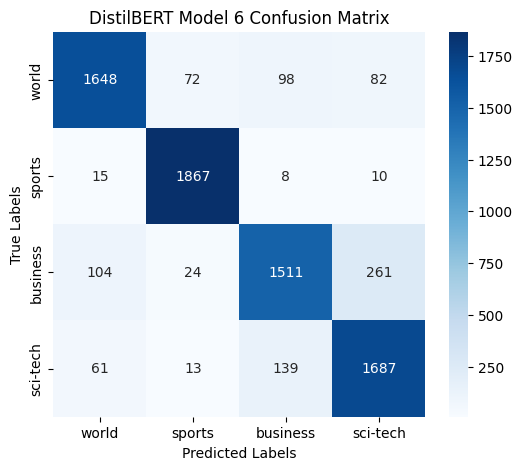

Model saved as /content/drive/MyDrive/DistilBERT_Models_400/model_6.pth
Best model updated!

Testing combination: Hidden Size=768, Dropout=0.5, Epoch=3


1it [00:00,  5.33it/s]

Epoch: 0, Loss:  1.356407880783081


25it [00:07,  3.27it/s]
1it [00:00,  2.53it/s]

Epoch: 1, Loss:  1.2636423110961914


25it [00:07,  3.17it/s]
1it [00:00,  2.50it/s]

Epoch: 2, Loss:  0.9536094665527344


25it [00:07,  3.17it/s]
475it [00:56,  8.36it/s]


Accuracy (test data) = 0.861578947368421
Classification report:
               precision    recall  f1-score   support

           0       0.81      0.91      0.86      1900
           1       0.95      0.98      0.97      1900
           2       0.82      0.79      0.80      1900
           3       0.86      0.77      0.82      1900

    accuracy                           0.86      7600
   macro avg       0.86      0.86      0.86      7600
weighted avg       0.86      0.86      0.86      7600



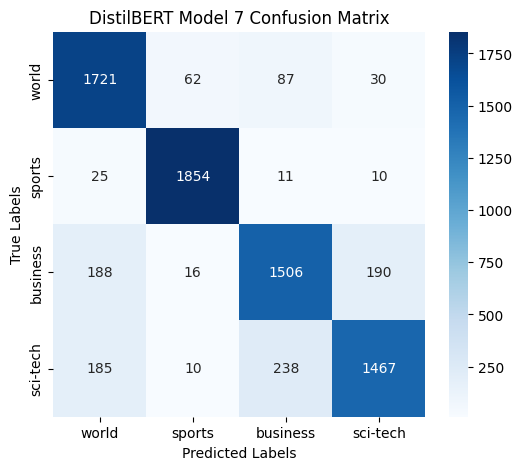

Model saved as /content/drive/MyDrive/DistilBERT_Models_400/model_7.pth

Testing combination: Hidden Size=768, Dropout=0.5, Epoch=5


1it [00:00,  7.87it/s]

Epoch: 0, Loss:  1.3651071786880493


25it [00:07,  3.29it/s]
1it [00:00,  2.58it/s]

Epoch: 1, Loss:  1.2636877298355103


25it [00:07,  3.18it/s]
1it [00:00,  2.52it/s]

Epoch: 2, Loss:  0.9925378561019897


25it [00:07,  3.17it/s]
1it [00:00,  2.53it/s]

Epoch: 3, Loss:  0.6513141989707947


25it [00:07,  3.17it/s]
1it [00:00,  2.51it/s]

Epoch: 4, Loss:  0.4601445496082306


25it [00:07,  3.17it/s]
475it [00:57,  8.22it/s]


Accuracy (test data) = 0.871578947368421
Classification report:
               precision    recall  f1-score   support

           0       0.95      0.82      0.88      1900
           1       0.95      0.97      0.96      1900
           2       0.75      0.89      0.81      1900
           3       0.87      0.81      0.84      1900

    accuracy                           0.87      7600
   macro avg       0.88      0.87      0.87      7600
weighted avg       0.88      0.87      0.87      7600



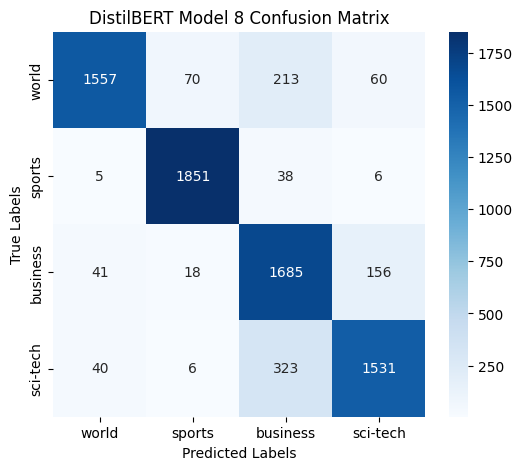

Model saved as /content/drive/MyDrive/DistilBERT_Models_400/model_8.pth

Best Model: Hidden Size=768, Dropout=0.2, Epoch=5
Best Accuracy: 0.8833%


In [17]:
# Hyperparameter tuning

# Mount Google Drive do save the model parameters
from google.colab import drive
import os
drive.mount('/content/drive')

# Path to save models in Google Drive
save_dir = "/content/drive/MyDrive/DistilBERT_Models_400"
os.makedirs(save_dir, exist_ok=True)

# Hyperparameter ranges
hidden_layer_sizes = [256, 768]
dropout_rates = [0.2, 0.5]
epoch_list = [3, 5]

# Generate all combinations
import itertools
all_combinations = list(itertools.product(hidden_layer_sizes, dropout_rates, epoch_list))

# Loss function for multiclass problem
loss_fn = torch.nn.CrossEntropyLoss()

# Save best model details
best_accuracy = 0.0
best_params = None

# Counter for saving models
model_counter = 1

# Training and validation loop
for hidden_size, dropout_rate, EPOCHS in all_combinations:
    print(f"\nTesting combination: Hidden Size={hidden_size}, Dropout={dropout_rate}, Epoch={EPOCHS}")

    model = DistilBERTClass(hidden_size, dropout_rate)
    model.to(device)

    optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-5)  # Fixed learning rate

    # Training loop
    for epoch in range(EPOCHS):
      train(model, epoch)

    # Validation loop
    outputs, targets = validation(model, testing_loader) # Takes model as input

    # Calculate accuracy
    output_probs = np.array(outputs)
    final_outputs = np.argmax(output_probs, axis = 1)
    targets_labels = np.array(targets)
    accuracy = np.mean(targets_labels == final_outputs)
    print(f"Accuracy (test data) = {accuracy}")
    print("Classification report:\n", classification_report(targets_labels, final_outputs))

    cm_bert = confusion_matrix(targets_labels, final_outputs, labels=[0,1,2,3])
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Blues', xticklabels=["world", "sports", "business", "sci-tech"], yticklabels=["world", "sports", "business", "sci-tech"])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f"DistilBERT Model {model_counter} Confusion Matrix")
    plt.show()

    # Save the current model
    model_path = os.path.join(save_dir, f"model_{model_counter}.pth")
    torch.save(model.state_dict(), model_path)
    print(f"Model saved as {model_path}")
    model_counter += 1

    # Update best model if needed
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = (hidden_size, dropout_rate, EPOCHS)
        print("Best model updated!")

# Final output
print(f"\nBest Model: Hidden Size={best_params[0]}, Dropout={best_params[1]}, Epoch={best_params[2]}")
print(f"Best Accuracy: {best_accuracy:.4f}%")